In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
import keras
from keras import layers
from PIL import Image 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import sklearn as sk
from sklearn.model_selection import train_test_split
import pickle

print(tf.__version__)

2024-11-09 12:50:25.133544: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-09 12:50:25.140097: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-09 12:50:25.148417: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-09 12:50:25.150951: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-09 12:50:25.157046: I tensorflow/core/platform/cpu_feature_guar

2.17.0


In [2]:
gpus = tf.config.list_physical_devices('GPU')
gpuid = 0 #int(args.gpu_id)                                                                                                                           
if gpus:
  # Restrict TensorFlow to only allocate X GB of memory on the first GPU                                                                              
  try:
    tf.config.set_visible_devices(gpus[gpuid], 'GPU')
    tf.config.set_logical_device_configuration(
        gpus[gpuid],
        [tf.config.LogicalDeviceConfiguration(memory_limit=8000)])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized                                                                                   
    print(e)

1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1731181827.041678 1096199 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731181827.065488 1096199 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731181827.068200 1096199 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
I0000 00:00:1731181827.072619 1096199 cuda_executor.cc:1015] successful NUMA node read from SysFS ha

In [3]:
inputs = np.load("all_inputs_down_samp.npy")
targets = np.load("all_targets_down_samp.npy")
# train test split
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2)

In [4]:
len(inputs)

3470

In [5]:
X_train.shape

(2776, 512, 512, 1)

In [6]:
X_train = np.squeeze(X_train)
y_train = np.squeeze(y_train)
X_test = np.squeeze(X_test)
y_test = np.squeeze(y_test)

In [7]:
model = keras.Sequential([
    layers.Flatten(input_shape=(512,512)),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')

])

model.summary()

/home/user/anaconda3/envs/tf/lib/python3.10/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 262144)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │   134,218,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,649,345 (513.65 MB)

 Trainable params: 134,647,297 (513.64 MB)

 Non-trainable params: 2,048 (8.00 KB)

In [8]:
model.compile(optimizer=Adam(learning_rate=10e-2),
              loss='binary_crossentropy',  
              metrics=['accuracy'])

In [9]:
model_checkpoint = ModelCheckpoint(
  filepath='checkpoint.FFNN3.keras',
  monitor='val_loss',
  mode='min',
  save_best_only=True)


optim = model.fit(X_train,y_train, 
                  epochs=30, 
                  validation_split =.2,
                  callbacks=[model_checkpoint]
                )

Epoch 1/30


I0000 00:00:1731181857.629764 1096354 service.cc:146] XLA service 0x70fbc0004910 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731181857.629785 1096354 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080 SUPER, Compute Capability 8.9
2024-11-09 12:50:57.648579: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-09 12:50:57.769989: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
2024-11-09 12:50:58.058168: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_956', 36 bytes spill stores, 40 bytes spill loads



13/70 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4455 - loss: 46.2763

I0000 00:00:1731181858.691407 1096354 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 55ms/step - accuracy: 0.4992 - loss: 19.5667 - val_accuracy: 0.5683 - val_loss: 0.6864
Epoch 2/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.5305 - loss: 0.7013 - val_accuracy: 0.5683 - val_loss: 0.6849
Epoch 3/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5425 - loss: 0.6906 - val_accuracy: 0.5683 - val_loss: 0.6839
Epoch 4/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 0.5280 - loss: 0.6929 - val_accuracy: 0.5683 - val_loss: 0.6838
Epoch 5/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5215 - loss: 0.6935 - val_accuracy: 0.5683 - val_loss: 0.6850
Epoch 6/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5031 - loss: 0.6950 - val_accuracy: 0.5683 - val_loss: 0.6840
Epoch 7/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.5389 - loss: 0.6907 - val_accuracy: 0.5683 - val_loss: 0.6843
Epoch 8/30
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.5003 - loss: 0.6934 - val_accuracy: 0.5683 - val_loss: 0

In [10]:
from tensorflow.keras.models import load_model

best_model = load_model('checkpoint.FFNN3.keras')

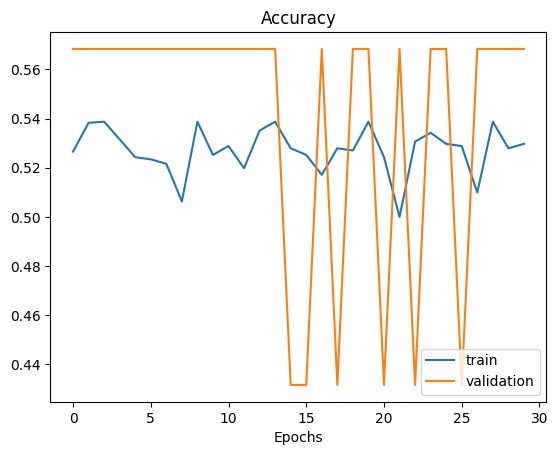

In [11]:
plt.plot(optim.history['accuracy'])
plt.plot(optim.history['val_accuracy'])
plt.legend(['train', 'validation'], loc='lower right')
plt.title('Accuracy')
plt.xlabel("Epochs")
plt.show()

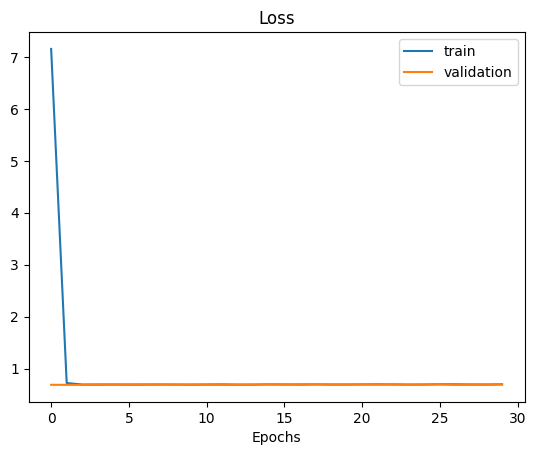

In [12]:
plt.plot(optim.history['loss'])
plt.plot(optim.history['val_loss'])
plt.legend(['train', 'validation'], loc='upper right')
plt.title('Loss')
plt.xlabel("Epochs")
plt.show()

In [14]:
test_loss, test_acc = model.evaluate(X_test, y_test)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5201 - loss: 0.6930


In [15]:
'Test loss:{0}, Test accuracy: {1}'.format(test_loss,test_acc)

'Test loss:0.6929791569709778, Test accuracy: 0.5288184285163879'

In [16]:
Y_pred_probs = best_model.predict(X_test)
Y_pred = np.array(Y_pred_probs>=.5)

22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


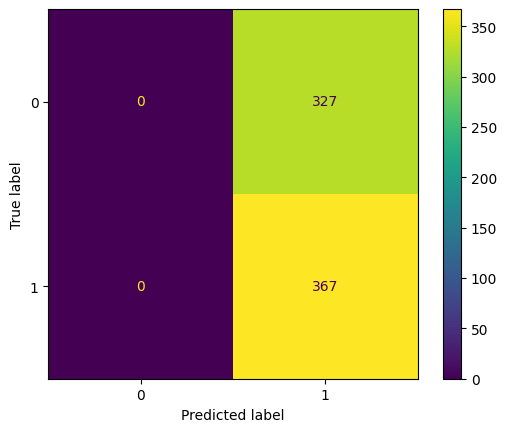

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, Y_pred) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()


In [25]:
sk.metrics.precision_score(y_test, Y_pred)

0.5288184438040345

In [26]:
sk.metrics.recall_score(y_test, Y_pred)

1.0

In [27]:
sk.metrics.accuracy_score(y_test, Y_pred)

0.5288184438040345

In [28]:
TP = 48
TN = 282
FP = 37
FN = 327

recall = TP/(TP+FN)
precision = TP/(TP+FP)
acc = (TP+TN)/(TP+TN+FP+FN)

print(f"recall:{recall}, precision: {precision}, accuracy: {acc}")

recall:0.128, precision: 0.5647058823529412, accuracy: 0.4755043227665706
